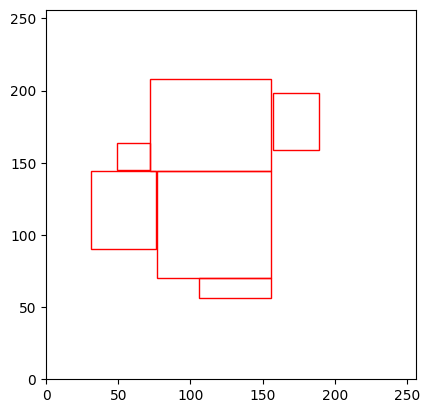

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the rectangles
rectangles = [(77, 112, 156, 186), (72, 48, 156, 112), (31, 112, 76, 166), (106, 186, 156, 200), (49, 92, 72, 111), (157, 58, 189, 97)]
rectangles = [[x, 255 - y1, x2, 255 - y2] for x, y1, x2, y2 in rectangles]
# Create figure and axis
fig, ax = plt.subplots()

# Set limits
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

# Add rectangles to the plot
for rect in rectangles:
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
ax.set_aspect('equal')
# Display the plot
plt.show()


In [2]:
from torch_geometric.data import Data
import torch
import numpy as np

In [3]:

from torch.nn import Linear
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv

In [4]:
def intersect(A,B):
    A, B = A[:,None], B[None]
    low = np.s_[...,:2]
    high = np.s_[...,2:]
    A,B = A.copy(),B.copy()
    A[high] += 1; B[high] += 1
    intrs = (np.maximum(0,np.minimum(A[high],B[high])
                        -np.maximum(A[low],B[low]))).prod(-1)
    return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)

def build_graph(bbs,temp):
    edges = []
    for k in range(len(bbs)):
        for l in range(len(bbs)):
            if l > k:
                bb0 = bbs[k]
                bb1 = bbs[l]
                #print(bbs,temp)
                bb2 = temp[k]
                bb3 = temp[l]
                if is_adjacent(bb0, bb1) and  manhattam(bb2,bb3):
                    edges.append([k, l])
                    edges.append([l, k])
    edges = np.array(edges)
    return edges

def is_adjacent(box_a, box_b, threshold=0.03):
        
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    h1, h2 = x1-x0, x3-x2
    w1, w2 = y1-y0, y3-y2
    xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
    yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0
    delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
    delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0
    delta = max(delta_x, delta_y)
    return delta < threshold

def manhattam(box_a, box_b):
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    if x2>=x1 and y2<=y1:
        return False
    elif x2>=x1 and y3>=y0:
        return False
    elif x3<=x0 and y3>=y0:
        return False
    elif x3<=x0 and y2<=y1:
        return False
    else:
        return True
rooms_bbs = np.array(rectangles)
temp=rooms_bbs
features = []
rooms_bbs_new = []
for i, bb in enumerate(rooms_bbs):
    x0, y0 = bb[0], bb[1]
    x1, y1 = bb[2], bb[3]
    #temp.append([x0,y0,x1,y1])
    xmin, ymin = min(x0, x1), min(y0, y1)
    xmax, ymax = max(x0, x1), max(y0, y1)
    l, b = xmax - xmin, ymax - ymin
    area = l*b
    if l<b:
        l, b = b, l
    features.append([area, l, b, 0, 0]) 
    rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
rooms_bbs = np.stack(rooms_bbs_new)
intersect = intersect(rooms_bbs,rooms_bbs)
for i in range(len(rooms_bbs)):
    for j in range(i+1,len(rooms_bbs)):
        if intersect[i,j]>0.7*intersect[j,j]:
            if intersect[i,i]>intersect[j,j]: #is i a parent
                features[i][4] = 1
                features[j][3] = 1
            else:   # i is child
                features[i][3] = 1
                features[j][4] = 1
        if intersect[i,j]>0.7*intersect[i,i]:
            if intersect[j,j]>intersect[i,i]: 
                features[j][4] = 1
                features[i][3] = 1
            else:
                features[j][3] = 1
                features[i][4] = 1

rooms_bbs = rooms_bbs/256.0
tl = np.min(rooms_bbs[:, :2], 0)
br = np.max(rooms_bbs[:, 2:], 0)
shift = (tl+br)/2.0 - 0.5
rooms_bbs[:, :2] -= shift
rooms_bbs[:, 2:] -= shift
tl -= shift
br -= shift
edges = build_graph(rooms_bbs,temp) 
#         labels = labels - 1
#         labels[labels>=5] = labels[labels>=5] - 1
x = torch.tensor(features, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
#y = torch.tensor(labels, dtype=torch.long)
d = Data(x=x, edge_index=edge_index)
print(d)

Data(x=[6, 5], edge_index=[2, 14])


In [5]:
import torch.nn.functional as F
class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(5, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier = Linear(16, 13)

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out = self.classifier(h)
        return out

In [6]:
models = {
    'mlp': Linear,
    'gcn': GCNConv,
    'gat': GATConv,
    'sage': SAGEConv,
    'tagcn': TAGConv,
}
model_type = 'tagcn'
hidden_layers = 2

In [7]:
# Load the saved model
loaded_model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
loaded_model.load_state_dict(torch.load('trained_model.pth',map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): TAGConv(5, 16, K=3)
  (layer2): ModuleList(
    (0): TAGConv(16, 16, K=3)
  )
  (classifier): Linear(in_features=16, out_features=13, bias=True)
)

In [8]:
with torch.no_grad():
    x, edge_index = d.x, d.edge_index
    new_predictions = loaded_model(x, edge_index)

In [9]:
new_predictions

tensor([[19.6577, 19.1572, 16.0103, 11.3212, 15.9886, 10.4278, 11.1756, 13.4409,
          9.4510, 13.7601, 13.3788, 12.9893, 10.2032],
        [24.1325, 21.5887, 17.8572, 11.0206, 18.8274, 13.3681, 13.8989, 17.2650,
         12.5980, 11.7008, 13.5085, 12.0072,  8.9507],
        [12.0213, 12.4570, 12.8713,  8.6467, 12.4724, 12.0722, 13.0741, 15.8364,
         11.0829,  6.0371,  6.8777,  6.3619,  4.5582],
        [-5.0809,  2.8110,  9.9800,  9.6323,  3.5381,  4.6122,  6.9502,  5.0972,
          2.8047, 15.3043,  6.5073,  8.2095,  7.2542],
        [-4.5426, -3.1955,  5.0474,  9.9094,  1.4233, -0.6915,  1.3607, -0.1371,
         -2.1426,  6.4763,  3.1811,  7.0487,  6.4493],
        [-5.2762, -1.6604,  9.6530,  8.9314,  3.5781,  5.3510,  7.8441,  6.3958,
          3.7852,  8.7173,  3.1681,  4.4224,  3.7077]])

In [10]:
# Define the threshold for selecting classes
threshold = 0.1

# Apply the softmax function to the logits to get probabilities
probs = F.softmax(new_predictions, dim=1)
probs

tensor([[6.0012e-01, 3.6381e-01, 1.5640e-02, 1.4380e-04, 1.5304e-02, 5.8852e-05,
         1.2432e-04, 1.1976e-03, 2.2160e-05, 1.6480e-03, 1.1255e-03, 7.6244e-04,
         4.7011e-05],
        [9.2034e-01, 7.2306e-02, 1.7323e-03, 1.8600e-06, 4.5703e-03, 1.9455e-05,
         3.3078e-05, 9.5809e-04, 9.0066e-06, 3.6722e-06, 2.2387e-05, 4.9886e-06,
         2.3473e-07],
        [1.7797e-02, 2.7513e-02, 4.1637e-02, 6.0923e-04, 2.7941e-02, 1.8725e-02,
         5.0997e-02, 8.0760e-01, 6.9631e-03, 4.4814e-05, 1.0387e-04, 6.2017e-05,
         1.0213e-05],
        [1.3884e-09, 3.7147e-06, 4.8240e-03, 3.4071e-03, 7.6861e-06, 2.2501e-05,
         2.3311e-04, 3.6543e-05, 3.6915e-06, 9.9017e-01, 1.4970e-04, 8.2127e-04,
         3.1594e-04],
        [4.6814e-07, 1.8005e-06, 6.8432e-03, 8.8468e-01, 1.8252e-04, 2.2023e-05,
         1.7145e-04, 3.8339e-05, 5.1602e-06, 2.8563e-02, 1.0586e-03, 5.0631e-02,
         2.7804e-02],
        [1.5570e-07, 5.7890e-06, 4.7421e-01, 2.3045e-01, 1.0906e-03, 6.4212e-03,

In [11]:
result=[]
for i, p in enumerate(probs):
    temp=[]
    for ind,j in enumerate(p):
        if(j>threshold):
            temp.append(ind)
    result.append(temp)

In [12]:
result

[[0, 1], [0], [7], [9], [3], [2, 3, 9]]

In [22]:
probs[0][0]

tensor(0.6001)

In [38]:
def calculate_score(combination, probs):
    print(combination)
    if combination is None:
        return 0
    score = sum(probs[i][j] for i, j in enumerate(combination))
    return score
def generate_combinations(arrays, current=[], index=0,probs=None):
    result = []
    if index == len(arrays):
        score=calculate_score(current, probs)
        return [(current,score)]

    for element in arrays[index]:
        result.extend(generate_combinations(arrays, current + [element], index + 1,probs))
    
    return result

arrays = [[0, 1], [0], [7], [9], [3], [2, 3, 9]]
combinations = generate_combinations(arrays,probs=probs)
print(combinations)

[0, 0, 7, 9, 3, 2]
[0, 0, 7, 9, 3, 3]
[0, 0, 7, 9, 3, 9]
[1, 0, 7, 9, 3, 2]
[1, 0, 7, 9, 3, 3]
[1, 0, 7, 9, 3, 9]
[([0, 0, 7, 9, 3, 2], tensor(4.6771)), ([0, 0, 7, 9, 3, 3], tensor(4.4334)), ([0, 0, 7, 9, 3, 9], tensor(4.3889)), ([1, 0, 7, 9, 3, 2], tensor(4.4408)), ([1, 0, 7, 9, 3, 3], tensor(4.1970)), ([1, 0, 7, 9, 3, 9], tensor(4.1526))]


In [68]:
len(combinations)

6

In [42]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master room",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}

In [70]:
# Assuming new_predictions is your tensor
predicted_categories = new_predictions.argmax(dim=1)
print(np.array(predicted_categories))

# Now you have the indices of the predicted categories
# You can map these indices to the actual room categories using your MOD_ROOM_CLASS dictionary
predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in predicted_categories]
predicted_room_categories

[0 0 7 9 3 2]


['Living room', 'Living room', 'Second room', 'Balcony', 'Bathroom', 'Kitchen']

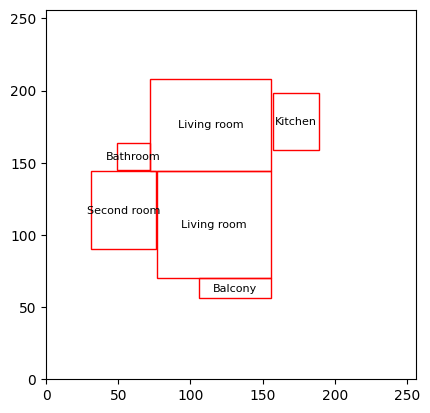

In [71]:
rectangles = [(77, 112, 156, 186), (72, 48, 156, 112), (31, 112, 76, 166), (106, 186, 156, 200), (49, 92, 72, 111), (157, 58, 189, 97)]
rectangles = [[x, 255 - y1, x2, 255 - y2] for x, y1, x2, y2 in rectangles]

# Define the labels
labels = ['Living room', 'Living room', 'Second room', 'Balcony', 'Bathroom', 'Kitchen']

# Create figure and axis
fig, ax = plt.subplots()

# Set limits
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

# Add rectangles to the plot
for rect, label in zip(rectangles, labels):
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
    # Calculate center coordinates of the rectangle
    center_x = (rect[0] + rect[2]) / 2
    center_y = (rect[1] + rect[3]) / 2
    # Add label at the center
    ax.text(center_x, center_y, label, fontsize=8, color='black', ha='center', va='center')  # Center the text

ax.set_aspect('equal')
# Display the plot
plt.show()


**Multiple Suggestions**

In [37]:
from torch_geometric.data import Data
import torch
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv

In [38]:
import torch.nn.functional as F
class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(5, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier = Linear(16, 13)

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out = self.classifier(h)
        return out

In [39]:
# Load the saved model
loaded_model = Model(layer_type=TAGConv, n_hidden=2)
loaded_model.load_state_dict(torch.load('trained_model.pth',map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): TAGConv(5, 16, K=3)
  (layer2): ModuleList(
    (0): TAGConv(16, 16, K=3)
  )
  (classifier): Linear(in_features=16, out_features=13, bias=True)
)

In [40]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master room",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}

In [41]:
def calculate_score(combination, probs):
    print(combination)
    if combination is None:
        return 0
    score = sum(probs[i][j] for i, j in enumerate(combination))
    return score
def generate_combinations(arrays, current=[], index=0,probs=None):
    result = []
    if index == len(arrays):
        score=calculate_score(current, probs)
        return [(current,score)]

    for element in arrays[index]:
        result.extend(generate_combinations(arrays, current + [element], index + 1,probs))
    
    return result

In [42]:
def intersect_(A,B):
    A, B = A[:,None], B[None]
    low = np.s_[...,:2]
    high = np.s_[...,2:]
    A,B = A.copy(),B.copy()
    A[high] += 1; B[high] += 1
    intrs = (np.maximum(0,np.minimum(A[high],B[high])
                        -np.maximum(A[low],B[low]))).prod(-1)
    return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)

def build_graph(bbs,temp):
    edges = []
    for k in range(len(bbs)):
        for l in range(len(bbs)):
            if l > k:
                bb0 = bbs[k]
                bb1 = bbs[l]
                #print(bbs,temp)
                bb2 = temp[k]
                bb3 = temp[l]
                if is_adjacent(bb0, bb1) and  manhattam(bb2,bb3):
                    edges.append([k, l])
                    edges.append([l, k])
    edges = np.array(edges)
    return edges

def is_adjacent(box_a, box_b, threshold=0.03):
        
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    h1, h2 = x1-x0, x3-x2
    w1, w2 = y1-y0, y3-y2
    xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
    yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0
    delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
    delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0
    delta = max(delta_x, delta_y)
    return delta < threshold

def manhattam(box_a, box_b):
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    if x2>=x1 and y2<=y1:
        return False
    elif x2>=x1 and y3>=y0:
        return False
    elif x3<=x0 and y3>=y0:
        return False
    elif x3<=x0 and y2<=y1:
        return False
    else:
        return True
def calculate_score(combination, probs):
    score = sum(probs[i][j] for i, j in enumerate(combination))
    return score
def fn(rectangles):
    rooms_bbs = np.array(rectangles)
    temp=rooms_bbs
    features = []
    rooms_bbs_new = []
    for i, bb in enumerate(rooms_bbs):
        x0, y0 = bb[0], bb[1]
        x1, y1 = bb[2], bb[3]
        #temp.append([x0,y0,x1,y1])
        xmin, ymin = min(x0, x1), min(y0, y1)
        xmax, ymax = max(x0, x1), max(y0, y1)
        l, b = xmax - xmin, ymax - ymin
        area = l*b
        if l<b:
            l, b = b, l
        features.append([area, l, b, 0, 0]) 
        rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
    rooms_bbs = np.stack(rooms_bbs_new)
    intersect = intersect_(rooms_bbs,rooms_bbs)
    for i in range(len(rooms_bbs)):
        for j in range(i+1,len(rooms_bbs)):
            if intersect[i,j]>0.7*intersect[j,j]:
                if intersect[i,i]>intersect[j,j]: #is i a parent
                    features[i][4] = 1
                    features[j][3] = 1
                else:   # i is child
                    features[i][3] = 1
                    features[j][4] = 1
            if intersect[i,j]>0.7*intersect[i,i]:
                if intersect[j,j]>intersect[i,i]: 
                    features[j][4] = 1
                    features[i][3] = 1
                else:
                    features[j][3] = 1
                    features[i][4] = 1

    rooms_bbs = rooms_bbs/256.0
    tl = np.min(rooms_bbs[:, :2], 0)
    br = np.max(rooms_bbs[:, 2:], 0)
    shift = (tl+br)/2.0 - 0.5
    rooms_bbs[:, :2] -= shift
    rooms_bbs[:, 2:] -= shift
    tl -= shift
    br -= shift
    edges = build_graph(rooms_bbs,temp) 
    #         labels = labels - 1
    #         labels[labels>=5] = labels[labels>=5] - 1
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    #y = torch.tensor(labels, dtype=torch.long)
    d = Data(x=x, edge_index=edge_index)
    with torch.no_grad():
        x, edge_index = d.x, d.edge_index
        new_predictions = loaded_model(x, edge_index)
    threshold=0.1
    probs = F.softmax(new_predictions, dim=1)
    result=[]
    for i, p in enumerate(probs):
        temp=[]
        for ind,j in enumerate(p):
            if(j>threshold):
                temp.append(ind)
        result.append(temp)
    #print(result)
    combinations = generate_combinations(result,probs=probs)
    return (combinations,d)

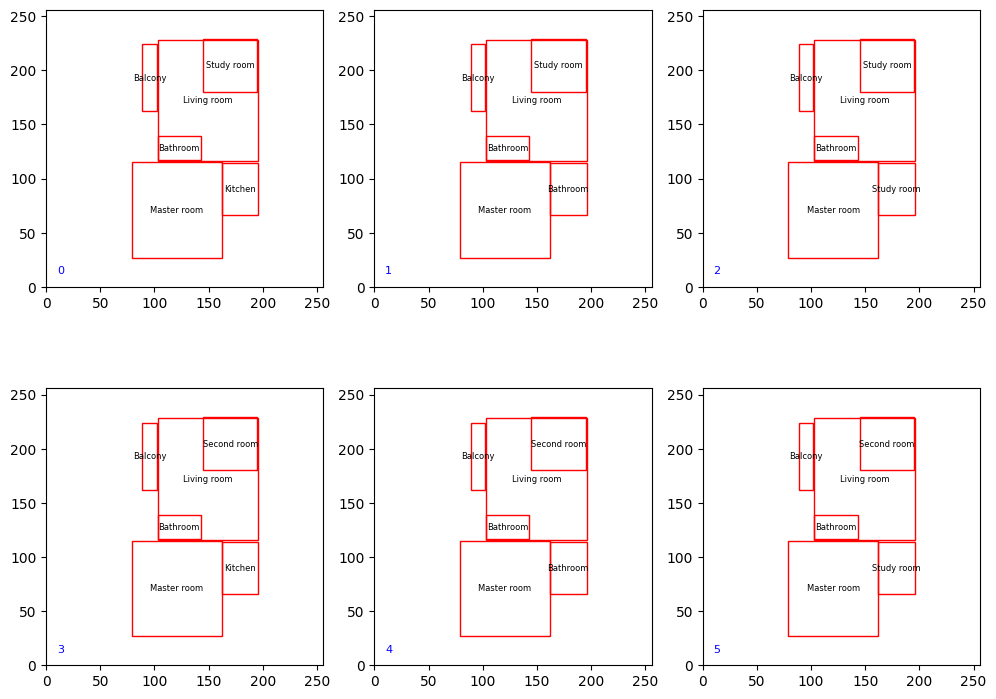

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

# Original rectangles
with open('rectangles.pkl', 'rb') as f:
    rectangles = pickle.load(f)
#rectangles = [(64, 89, 143, 163), (59, 19, 145, 89), (60, 18, 86, 53), (84, 3, 146, 19), (143, 89, 201, 143), (142, 142, 183, 163), (35, 87, 63, 116)]
rectangles = [[x, 255 - y1, x2, 255 - y2] for x, y1, x2, y2 in rectangles]

combinations,d=fn(rectangles)
labels_list=[]
scores_list=[]
for i in range(len(combinations)):
    predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in np.array(combinations[i][0])]
    labels_list.append(predicted_room_categories)
    scores_list.append(combinations[i][1])

# Calculate number of rows and columns
num_plots = len(labels_list)
cols = 3  # Number of columns
rows = -(-num_plots // cols)  # Ceiling division to ensure we have enough rows

fig, axs = plt.subplots(rows, cols, figsize=(10, 4*rows))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing
j=0
for ax, labels, score in zip(axs, labels_list, scores_list):
    # Set limits
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    
    # Add rectangles to the plot
    for rect, label in zip(rectangles, labels):
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
        # Calculate center coordinates of the rectangle
        center_x = (rect[0] + rect[2]) / 2
        center_y = (rect[1] + rect[3]) / 2
        # Add label at the center
        ax.text(center_x, center_y, label, fontsize=6, color='black', ha='center', va='center')  # Center the text
    ax.text(10, 10, f'{j}', fontsize=8, color='blue', ha='left', va='bottom')
    j+=1

    ax.set_aspect('equal')

# Hide any empty subplots
for i in range(num_plots, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
# Display the plot
plt.show()

**Vastu Shastra**

In [44]:
def center_of_plot(boxes):
    # Calculate the minimum and maximum x and y coordinates
    x_min = min(min(box[0], box[2]) for box in boxes)
    x_max = max(max(box[0], box[2]) for box in boxes)
    y_min = min(min(box[1], box[3]) for box in boxes)
    y_max = max(max(box[1], box[3]) for box in boxes)

    # Calculate the center of the floorplan
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return (center_x,center_y)

In [45]:
vastu_scores = {
    0: [7, 6, 5, 4, 3, 2, 1, 0, 7],
    1: [3, 0, 2, 1, 6, 7, 5, 4, 3],
    2: [2, 0, 5, 7, 3, 1, 4, 6, 2],
    3: [4, 0, 3, 2, 5, 1, 6, 7, 4],
    4: [6, 5, 7, 4, 1, 0, 2, 3, 6],
    5: [5, 3, 4, 6, 1, 0, 2, 7, 5],
    6: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    7: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    8: [6, 4, 5, 3, 1, 0, 2, 7, 6],
    9: [5, 6, 4, 3, 2, 1, 0, 7, 5],
    10: [5, 7, 6, 3, 1, 0, 2, 4, 5],
    11: [6, 4, 5, 3, 1, 0, 2, 7, 6],
    12: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    13: [5, 7, 6, 3, 1, 0, 2, 4, 5]
}

In [46]:
import math
(center_x,center_y)=center_of_plot(rectangles)
orientation=[]
#vastu=[]
result=[]
index=0
for i in range(len(rectangles)):
    # Calculate centroid
    x0,y0,x1,y1=rectangles[i]
    y_centroid = (y0 + y1) / 2
    x_centroid = (x0 + x1) / 2
    #print(x_centroid,y_centroid)

    deltaX = x_centroid - center_x
    deltaY = y_centroid - center_y

    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180

    if degrees_temp < 0:
        degrees_final = 360 + degrees_temp
    else:
        degrees_final = degrees_temp
    
    compass_brackets = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
    compass_lookup = round(degrees_final / 45)
    orientation.append(compass_lookup)
    #orientation.append(compass_brackets[compass_lookup])
    #vastu.append(vastu_scores[c][compass_lookup])
    room_types=combinations[index][0]
    result.append([room_types[i],compass_lookup])
print(result)

[[0, 0], [6, 1], [1, 4], [2, 3], [3, 6], [9, 7]]


In [47]:
data = torch.tensor(result, dtype=torch.float)
data

tensor([[0., 0.],
        [6., 1.],
        [1., 4.],
        [2., 3.],
        [3., 6.],
        [9., 7.]])

In [48]:
class Model1(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model1, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(2, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier = Linear(16, 14)

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out = self.classifier(h)
        return out

In [49]:
loaded_model = Model1(layer_type=Linear, n_hidden=2)
loaded_model.load_state_dict(torch.load('MLP_vastu_trained_model.pth',map_location=torch.device('cpu')))
loaded_model

Model1(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (classifier): Linear(in_features=16, out_features=14, bias=True)
)

In [50]:
with torch.no_grad():
    x, edge_index = data, d.edge_index
    new_predictions = loaded_model(x, _)

In [51]:
new_predictions

tensor([[-1.5298e+02, -4.5797e+01, -4.0873e+01, -1.3808e+02,  8.3003e+01,
         -5.4208e+01,  8.1126e+01,  9.5494e+01, -1.3078e+02, -1.2726e+02,
         -1.2956e+02, -9.7761e+01, -1.3972e+02, -1.1470e+02],
        [-1.4775e+01,  6.1743e+00, -1.0196e+01,  1.4514e+01,  2.4440e+01,
          2.7335e+01,  2.3353e+01, -1.1133e-01, -4.2998e+01, -4.5831e+01,
         -4.4165e+01, -3.9946e+01, -4.7245e+01, -4.3103e+01],
        [-3.8450e+01,  1.4010e+01,  1.3448e-01, -1.6029e+01,  7.3727e+00,
          9.8325e+00,  2.0415e+01,  1.7077e+01, -5.5708e+01, -5.7806e+01,
         -6.9179e+01, -7.1958e+01, -7.1148e+01, -6.2004e+01],
        [ 2.5723e+00,  8.8753e+00,  7.9341e+00, -9.2111e+00, -5.0590e+00,
          9.0052e+00,  9.4179e-01,  1.0517e+01, -4.2722e+01, -4.2506e+01,
         -5.4578e+01, -5.1409e+01, -5.3981e+01, -4.4205e+01],
        [-2.4709e+01,  1.5845e+01,  7.0059e+00,  1.2381e+01,  1.5138e+01,
          1.2133e+01,  1.8252e+01,  1.6236e+01, -8.8291e+01, -9.0347e+01,
         -1.

In [52]:
predicted_categories = new_predictions.argmax(dim=1)
print(predicted_categories)

tensor([7, 5, 6, 7, 6, 7])


In [53]:
total_sum = torch.sum(predicted_categories).item()
max_possible_sum = 7 * len(predicted_categories)
score = (total_sum / max_possible_sum) * 100

print("Vastu Compliance Score:", score)

Vastu Compliance Score: 90.47619047619048


In [ ]:
#8000